Running inference on image pairs
============================

If you want to use a pre-trained PWC-Net model on your own set of images, you can pass a list of image pairs to a `ModelPWCNet` object using its  `predict_from_img_pairs()` method, as demonstrated here.

Below, look for `TODO` references and customize this notebook based on your own needs.
"""
pwcnet_predict_from_img_pairs.ipynb

Run inference on a list of images pairs.

Written by Phil Ferriere

Licensed under the MIT License (see LICENSE for details)
"""

In [1]:
from __future__ import absolute_import, division, print_function
from copy import deepcopy
from skimage.io import imread
from model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_TEST_OPTIONS
from visualize import display_img_pairs_w_flows
from tqdm import tqdm
from optflow import flow_write, flow_write_as_png
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import copy
import numpy as np

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpu_devices = ['/device:GPU:1']  
controller = '/device:GPU:1'

/opt/anaconda3/envs/test2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/test2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/test2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/test2/lib/python3.7/site-packages/tensorflow/python/f






100%|██████████| 1/1 [00:00<00:00, 343.49it/s]

INFO:tensorflow:Restoring parameters from /home/dh/tempp/Weights/pwcnet.ckpt-761000







Predicting flows:   0%|                                                       | 0/1 [00:00<?, ?it/s]


Model Configuration:
  verbose                False
  ckpt_path              /home/dh/tempp/Weights/pwcnet.ckpt-761000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:GPU:1']
  controller             /device:GPU:1
  batch_size             1
  use_tf_data            True
  use_mixed_precision    False
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_dense_cx           True
  use_res_cx             True
  mode                   test
  trainable params       14079050







Predicting flows: 100%|###############################################| 1/1 [00:01<00:00,  1.00s/it]


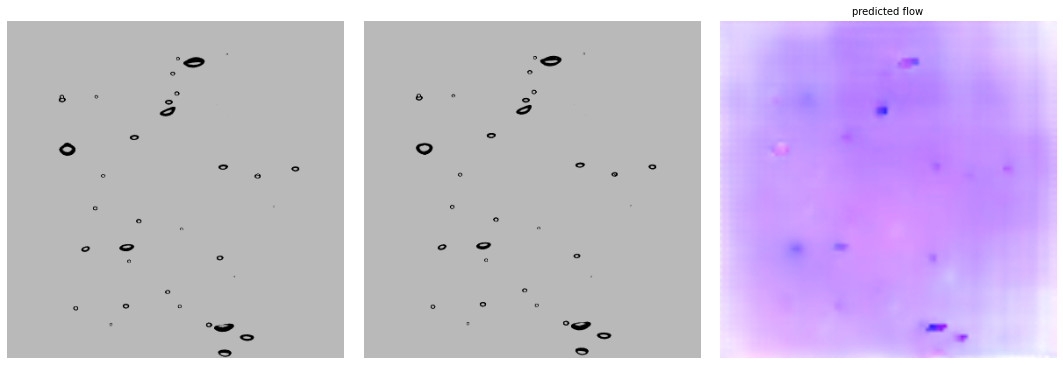






  0%|          | 0/1 [00:00<?, ?it/s]




100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


In [14]:
file_dir_save = f'/home/dh/tempp/Outputs/'
file_dir_sample = f'/home/dh/tempp/Sample Images/'

# TODO: Set the path to the trained model (make sure you've downloaded it first from http://bit.ly/tfoptflow)
ckpt_path = '/home/dh/tempp/Weights/pwcnet.ckpt-761000'

#Choose data type
img_pairs = []
for start_idx in tqdm(range(1,2)):
    image_path1 = file_dir_sample+f'Img_{start_idx:04d}.png'
    image_path2 = file_dir_sample+f'Img_{start_idx +1:04d}.png'
    image1, image2 = imread(image_path1), imread(image_path2)


    # If image is of 24bit, following section can be neglected
    img1 = np.zeros((image1.shape[0], image1.shape[1], 3))
    img1[:,:,0] = image1[:,:]
    img1[:,:,1] = image1[:,:]
    img1[:,:,2] = image1[:,:]

    img2 = np.zeros((image1.shape[0], image1.shape[1], 3))
    img2[:,:,0] = image2[:,:]
    img2[:,:,1] = image2[:,:]
    img2[:,:,2] = image2[:,:]

    img1 = img1.astype(np.uint8)
    img2 = img2.astype(np.uint8)

    img_pairs.append((img1, img2))

# Configure the model for inference, starting with the default options
nn_opts = deepcopy(_DEFAULT_PWCNET_TEST_OPTIONS)
nn_opts['verbose'] = False
nn_opts['ckpt_path'] = ckpt_path
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller

# We're running the PWC-Net-large model in quarter-resolution mode
# That is, with a 6 level pyramid, and upsampling of level 2 by 4 in each dimension as the final flow prediction
nn_opts['use_dense_cx'] = True
nn_opts['use_res_cx'] = True
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 2

# The size of the images in this dataset are not multiples of 64, while the model generates flows padded to multiples
# of 64. Hence, we need to crop the predicted flows to their original size
#nn_opts['adapt_info'] = (1, 401, 400, 2)

# Instantiate the model in inference mode and display the model configuration
nn = ModelPWCNet(mode='test', options=nn_opts)
nn.print_config()

# Generate the predictions and display them
pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=12, verbose=True)
display_img_pairs_w_flows(img_pairs, pred_labels)

############################################################# save in dat

num_pairs = np.array(pred_labels).shape[0]

for pair in tqdm(range(0, num_pairs)):
    flopng_dir = file_dir_save + f'Res1_floVis_{pair+1:04d}.png'
    msk_dir = file_dir_sample + f'msk_{pair+1:04d}.png'

    image_mask = imread(msk_dir)
    image_mask = image_mask.astype(np.uint8)

    mat_array = np.array(pred_labels)[pair,:,:,:]

    flow_write_as_png(mat_array, flopng_dir)


    mat_array = np.flipud(mat_array)

    u = mat_array[:,:,0]
    v = mat_array[:,:,1]

    u = np.flip(u, 0)
    v = np.flip(v, 0)


    u_rmvd = np.multiply(u,1-image_mask/255)
    v_rmvd = np.multiply(v,1-image_mask/255)

    mat_save = np.zeros((u.shape[1]*u.shape[0], 4))
    cnt=0

    for mat_j in range(0,u.shape[0]): #vertical
        for mat_i in range(0,u.shape[1]): #horizontal
            mat_save[cnt,0] = mat_i
            mat_save[cnt,1] = u.shape[0]-mat_j
            mat_save[cnt,2] = u_rmvd[mat_j, mat_i]
            mat_save[cnt,3] = -v_rmvd[mat_j, mat_i]
            cnt=cnt+1


    plt_dir = file_dir_save + f'Res2_velfld_{pair+1:04d}.txt'
    np.savetxt(plt_dir, mat_save, fmt="%s")

    #We read the existing text from file in READ mode
    src=open(plt_dir,"r")
    fline="variables=\"x\",\"y\",\"u\",\"v\"\nzone t=zone1, i=384, j=384, f=point\n"    #Prepending string

    oline=src.readlines()
    #Here, we prepend the string we want to on first line
    oline.insert(0,fline)
    src.close()
    #We again open the file in WRITE mode 
    src=open(plt_dir,"w")
    src.writelines(oline)
    src.close()

